<a href="https://colab.research.google.com/github/joaobecker/deep_learning_furniture/blob/master/furniture_caps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Furniture & Home Goods Recognition
  As shoppers move online, it’d be a dream come true to have products in photos classified automatically. But, automatic product recognition is challenging because, for the same product, a picture can be taken in different lighting, angles, backgrounds, and levels of occlusion. Meanwhile different fine-grained categories may look very similar, for example, ball chair vs egg chair for furniture, or dutch oven vs french oven for cookware. Therefore, it is time-consuming and hard for a human to categorize manually each type of furniture. This project aims to end with this problem by developing an algorithm that will help online stores move towards automatic product recognition and accurately assign category labels for furniture and home goods images.


### Data

  The project will be using the data available on Kaggle competition -* iMaterialist Challenge (Furniture) at FGVC5*, and it will apply deep learning, convolutional neural networks, to learn from previous images and identify which category each furniture falls into. 


### Data Wrangling
The data provided on Kaggle was on a json file, which means that it only provided the URLs for the images. Thus, first we had to transform the json file into a dataframe and then clean it to make the URLs available in a format that we can easily use to fetch the images from the web and download to our machine. 


### Exploratory Data Analysis
  By performing exploratory data analysis we found that the data comprises of 128 different categories of furniture and home goods, and a total of 194828 images. 
  We found that the two categories with most images had close to 4000 images each, then the amount of images lowers down to 1000 to 2500 for most of the categories.
  To be able to perform different models and experiment different strategies in our computer, we decided to use only 8 categories with the least images on the dataset. This resulted us having a total of 3699 images.
  Finally, we load some of the images to visualize how the furniture and home goods in our dataset looks like.
  

### Deep Learning Models
  The project leverages the power of transfer learning to use the weights and architecture of two models that has been previously trained in millions of images. These two models are VGG-16 and InceptionV3.

#### VGG-16
-	The project applied different transfer learning techniques on the VGG-16 model. We first use the pre-trained model as a feature extractor and then we fine-tuned the pre-trained model.
  - The pre-trained model as feature extractor without regularization achieved an accuracy of 93.4% and validation accuracy of 85%. 
- The pre-trained model as feature extractor with regularization achieved an accuracy of 78.9% and validation accuracy of 83%.
  - By fine-tuning the pre-trained model we achieved a result very similar to feature extraction without regularization, accuracy of 93.4% and validation accuracy of 83.6%

#### InceptionV3
-	We used this pre-trained model just as feature extractor. The model was able to achieve a slightly higher accuracy than VGG-16, 93.6% accuracy. However, the validation accuracy was significantly lower, 78.2%.


### Results
-	By leveraging transfer learning from VGG-16 model as feature extractor to our model and image augmentation, we achieved an impressive result of 93.6% accuracy and 85% validation accuracy, even though we only had a total of 3’699  images available in our dataset. Thus, being able to prove that you don’t need to have large dataset with hundreds of thousands of images to get good results.


Enabling imports from google drive

In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Wrangling

In [0]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from IPython.core.display import HTML  # for plotting images in a more simple format
from pandas.io.json import json_normalize

Importing json file from Google Drive.

In [0]:
#load data
data = json.load(open('drive/My Drive/furniture_categories/imaterialist-challenge-furniture-2018/train.json'))

To visualize how the json file is formatted, we first call *json_normalize*.
  - As we can see below, the main structure has two columns and a dictionary inside.
  - So, we will divide both columns to understand the structure of the data.

In [4]:
json_normalize(data)

,annotations,images
0,"[{'image_id': 1, 'label_id': 5}, {'image_id': ...",[{'url': ['https://img13.360buyimg.com/imgzone...


- Normalizing the annotation column
  - As we can see, the annotation column gives us the label id for each image
    - So, we will store this dataframe as labels

In [5]:
labels = json_normalize(data['annotations'])
labels.head()

,image_id,label_id
0,1,5
1,2,5
2,3,5
3,4,5
4,5,5


- Normalizing the images column
  - As we can see, the annotation column gives us the url id for each image
    - So, we will store this dataframe as images

In [6]:
images = json_normalize(data['images'])
images.head()

,image_id,url
0,1,[https://img13.360buyimg.com/imgzone/jfs/t2857...
1,2,[http://www.tengdakeli.cn/350/timg01/uploaded/...
2,3,[https://img13.360buyimg.com/imgzone/jfs/t8899...
3,4,[http://img4.tbcdn.cn/tfscom/i1/2855447419/TB2...
4,5,[http://a.vpimg4.com/upload/merchandise/287883...


- Now that we have normalized both columns and have a proper dataframe, we will perform a inner join.
  - The inner join will be based on image_id, as it is what represents each images and label in both sets

In [7]:
train_data = images.merge(labels, how='inner', on=['image_id'])
train_data.head()

,image_id,url,label_id
0,1,[https://img13.360buyimg.com/imgzone/jfs/t2857...,5
1,2,[http://www.tengdakeli.cn/350/timg01/uploaded/...,5
2,3,[https://img13.360buyimg.com/imgzone/jfs/t8899...,5
3,4,[http://img4.tbcdn.cn/tfscom/i1/2855447419/TB2...,5
4,5,[http://a.vpimg4.com/upload/merchandise/287883...,5


In [8]:
type(train_data['url'][0])

list

- Nice, now we have a proper data set.
  - However, there is something weird, the url column is a list.
    - For us to get the image from the url, the url needs to be a string, and not a list. So, let's change that.

In [0]:
url = [''.join(map(str, image)) for image in train_data.url]
train_data['url'] = url

- Done, now if we call the type function on the url, it will show us that it is a string.

In [10]:
train_data.head()

,image_id,url,label_id
0,1,https://img13.360buyimg.com/imgzone/jfs/t2857/...,5
1,2,http://www.tengdakeli.cn/350/timg01/uploaded/i...,5
2,3,https://img13.360buyimg.com/imgzone/jfs/t8899/...,5
3,4,http://img4.tbcdn.cn/tfscom/i1/2855447419/TB2S...,5
4,5,http://a.vpimg4.com/upload/merchandise/287883/...,5


In [11]:
type(train_data['url'][0]) # calling type on url

str

Now that our dataset is looking good, let's explore the data.

# Exploratory Data Analysis

In [12]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194828 entries, 0 to 194827
Data columns (total 3 columns):
image_id    194828 non-null int64
url         194828 non-null object
label_id    194828 non-null int64
dtypes: int64(2), object(1)
memory usage: 10.9+ MB


In [13]:
len(train_data['label_id'].value_counts())

128

- Our dataset has a total of 194 828 data images and 128 unique categories of furnitures and home goods.
  - Now, let's see which are the most and least represented categories in our dataset.

In [14]:
# Top 10 categories
print(train_data['label_id'].value_counts().head(10))

# Total amount of categories
print("Amount of furniture categories - {}".format(len(train_data['label_id'].value_counts())))

20     3996
42     3973
92     2666
12     2609
125    2598
21     2577
122    2462
3      2368
89     2353
93     2350
Name: label_id, dtype: int64
Amount of furniture categories - 128


We can see that the most represented category has almost twice the amount of images than the 10th category most represented.
  - Now, let's see in a graph how the top 50 categories are represented by images.

Text(0, 0.5, 'Amount of images')

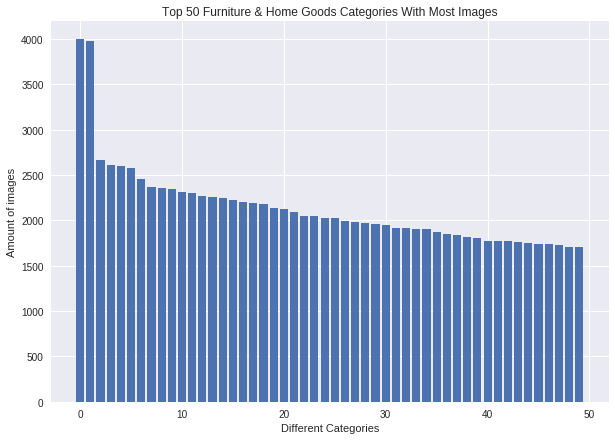

In [107]:
# Top fifty categories with most images
top_fifty = train_data['label_id'].value_counts().head(50)


plt.figure(figsize=(10,7))
plt.bar(np.arange(50), top_fifty)
plt.title('Top 50 Furniture & Home Goods Categories With Most Images')
plt.xlabel('Different Categories')
plt.ylabel('Amount of images')

Now, let's see the bottom 50 categories

Text(0, 0.5, 'Amount of images')

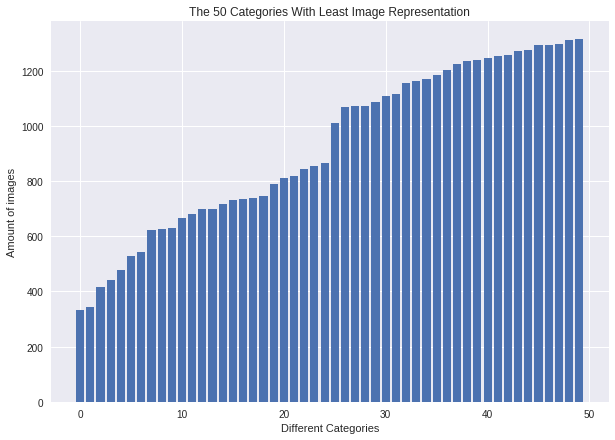

In [16]:
# The 50 categories with least image representation
bottom_fifty = train_data['label_id'].value_counts(ascending=True).head(50)

plt.figure(figsize=(10,7))
plt.bar(np.arange(50), bottom_fifty)
plt.title('The 50 Categories With Least Image Representation')
plt.xlabel('Different Categories')
plt.ylabel('Amount of images')

From the graphs above, we can see that there are 2 categories that have close to 4000 images, but then the amount of images to each category declines, and most categories have more than 1000 images.

#### Visualizing Images

At this section, we will create a function to visualize random image of diffferent categories of furniture and home goods available in our dataset.

In [0]:
def display_image(label_id, number_of_display, seed=123):
    labeled_data = train_data[train_data.label_id == label_id] # Select the part of the data that contains the id you want to display
    labeled_data = labeled_data.sample(number_of_display, random_state=seed) # Randomly select the amount of data you selected to display
    img_style = "width: 180px; margin: 4px; float: left; border: 1px solid black;"  # CSS, setting the formate to display images.
    images_list = ''.join([f"<img style='{img_style}' src='{u}' />" for u in labeled_data.url]) # HTML, with a comprehension list to join the images we want 
    display(HTML(images_list))

In [18]:
# Select the furniture with label id equal to 70 and display 9 images
display_image(label_id=70, number_of_display=9)

In [19]:
# Select the furniture with label id equal to 25 and display 9 images
display_image(label_id=25, number_of_display=9)

In [20]:
# Select the furniture with label id equal to 3 and display 9 images
display_image(label_id=3, number_of_display=9)

# Downloading and Manipulating Images from URLs

Since this is a large dataset, with more than 194'000 images, it will take a long time to import all these images to the machine and it will require a powerful computer to apply any deep learning algorithm.
  - Therefore, we will be using a subset dataset, containing only 8 categories of furniture and home goods with the least images.

In [21]:
bottom_eight = train_data['label_id'].value_counts(ascending=True).head(8).index  # Selecting the 8 label ids with the least images

furniture = train_data[train_data['label_id'].isin(bottom_eight)]  # Creating a dataset with only the 8 label ids selected above
furniture.head()

,image_id,url,label_id
8478,8479,https://img14.360buyimg.com/imgzone/jfs/t3532/...,9
8479,8480,https://img13.360buyimg.com/imgzone/jfs/t3856/...,9
8480,8481,https://img10.360buyimg.com/imgzone/jfs/t3238/...,9
8481,8482,https://img.alicdn.com/imgextra/TB2.lt3aV6.F1J...,9
8482,8483,https://img14.360buyimg.com/imgzone/jfs/t16030...,9


Now, we will create a function to download the images from the URLs and store in our machine.

In [0]:
from tqdm import tqdm
import urllib3 #Url Opener

http = urllib3.PoolManager(50)
failed = [] # store the id of failed images.


def download_img(id_, url_):
    try: 
        req = http.request('GET',url_)
        f = open("drive/My Drive/furniture_categories/imaterialist-challenge-furniture-2018/train/"+str(id_)+".jpg",'wb')
        f.write(req.data)
        f.close()
    except:
        failed.append(str(id_))

In [0]:
from multiprocessing.pool import ThreadPool as Pool # from multiprocessing import Pool

pool_size = 100  # your "parallelness"
pool = Pool(pool_size)

Since we have already downloaded the images, this part is commented out, so we don't download it twice.

In [0]:
#  for index,x in tqdm(furniture.iterrows()):
#     pool.apply_async(download_img, (x['image_id'],x['url'],))
    
# pool.close()
# pool.join()

### Importing The Downloaded Images 

To import the downloaded images we will first create a new column with the path of each image in our folder.
  - Since we named each image with its image_id, all we need to do now is to join the path with the image_id in and  '.jpg'

In [25]:
filename = [ 'drive/My Drive/furniture_categories/imaterialist-challenge-furniture-2018/train/' + str(id) + '.jpg'  for id in furniture['image_id']]
furniture['filename'] = filename
furniture.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,image_id,url,label_id,filename
8478,8479,https://img14.360buyimg.com/imgzone/jfs/t3532/...,9,drive/My Drive/furniture_categories/imateriali...
8479,8480,https://img13.360buyimg.com/imgzone/jfs/t3856/...,9,drive/My Drive/furniture_categories/imateriali...
8480,8481,https://img10.360buyimg.com/imgzone/jfs/t3238/...,9,drive/My Drive/furniture_categories/imateriali...
8481,8482,https://img.alicdn.com/imgextra/TB2.lt3aV6.F1J...,9,drive/My Drive/furniture_categories/imateriali...
8482,8483,https://img14.360buyimg.com/imgzone/jfs/t16030...,9,drive/My Drive/furniture_categories/imateriali...


In [26]:
furniture.shape

(3699, 4)

### Manipulating images

In [27]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array, load_img
import re

Using TensorFlow backend.


Below, it is for loop to load the image, transform it into an array and then add to a list called furniture_data. If there is an issue with loading the image, it will add the image_id of the image in an error list, so we can then remove it from our dataframe.

In [28]:
furniture_data = []
errors = []

for img in tqdm(furniture['filename'].values.tolist()):
  try:
    loaded = load_img(img, target_size=(299, 299))  # Load the image with size 299x299
    to_array = img_to_array(loaded) # Transforming the image into numbers
    furniture_data.append(to_array) # append to our list furniture_data
  except: 
    id = int(re.search(r'\d+', img.split('/')[5]).group())  # If we cannot load the image, get the id of the image
    errors.append(id) # Store the id of the image we were not able to load

100%|██████████| 3699/3699 [13:43<00:00,  4.67it/s]


Now, we will delete the images that had an error when loading.

In [29]:
# Drop the image_id of the images we were not able to load

df_furn = furniture.copy()

for row in tqdm(errors):
  df_furn = df_furn[df_furn['image_id'] != row]

100%|██████████| 232/232 [00:00<00:00, 999.22it/s]


Now, we will transform the furniture_data list (with all the images as integers) in an array, and create a training, validation and test set.

In [0]:
furniture_data = np.array(furniture_data)

In [0]:
x_train, x_test, y_train, y_test = train_test_split(furniture_data, df_furn['label_id'], test_size=0.3, stratify=np.array(df_furn['label_id']), random_state=42)

In [0]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, stratify=np.array(y_train), random_state=42)

In [33]:
#print('Initial Dataset Size:', furniture_data.shape)
print('Initial Train and Test Datasets Size:', x_train.shape, x_test.shape)
print('Train and Validation Datasets Size:', x_train.shape, x_val.shape)
print('Train, Test and Validation Datasets Size:', x_train.shape, x_test.shape, x_val.shape)

Initial Train and Test Datasets Size: (2062, 299, 299, 3) (1041, 299, 299, 3)
Train and Validation Datasets Size: (2062, 299, 299, 3) (364, 299, 299, 3)
Train, Test and Validation Datasets Size: (2062, 299, 299, 3) (1041, 299, 299, 3) (364, 299, 299, 3)


As we can see above, we now have the training, test and validation sets. 
To make it easier for our model to understand our label we will transform to one-hot encoded labels.

In [34]:
y_train_ohe = pd.get_dummies(y_train).as_matrix()
y_test_ohe = pd.get_dummies(y_test).as_matrix()
y_val_ohe = pd.get_dummies(y_val).as_matrix()

print(y_train_ohe.shape, y_test_ohe.shape, y_val_ohe.shape)

(2062, 8) (1041, 8) (364, 8)


Since we selected the type of furnitures with less images, we will leverage image augmentation to create more images by slightly modifying the ones we currently have. We will do this by using ImageDataGenerator from keras.

In [0]:
from keras.preprocessing.image import ImageDataGenerator
BATCH_SIZE = 32


# Training Data
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   zoom_range = 0.3, # zooming the image randomly by a factor of 0.3 
                                   rotation_range = 30, # rotating the image randomly by 30 degrees
                                   width_shift_range = 0.2, # translating the image randomly horizontally by 0.2 factor
                                   height_shift_range = 0.2, # translating the image randomly vertically by 0.2 factor
                                   horizontal_flip = 'true') # Randomly flipping half of the images.

train_generator = train_datagen.flow(x_train, y_train_ohe, shuffle = False, 
                                     batch_size = BATCH_SIZE, seed = 42)

# Validation Data

val_datagen = ImageDataGenerator(rescale = 1./255)
val_generator = train_datagen.flow(x_val, y_val_ohe, shuffle = False, 
                                   batch_size = BATCH_SIZE, seed = 42)   

Now, we have all the data we need and ready to use it in a model.

# Deep Learning - Convolutional Neural Network

Since we only have 2062 images in our training set, we will leverage tranfer learning to use the weights and architecture of a model that has been previously trained in millions of images.

What does transfer learning means?
  - The objective of training a neural network is to correctly identify the weights for the network by multiple forward backward propagations. Therefore, by using a pre-trained model which has been previously trained on a large dataset, we can directly use the weights and architecture obtained and apply the learning on our problem.
    - On top of training millions of images, some of these models are very deep, meaning that they use a lot of layers. This type of computation is not possible in a normal computer and even if we use a powerful CPU, it would take days to compute it. 
  - This project will be using transfer learning in two different pre-trained models:
    - VGG-16 model - This model has been pre-trained on a huge dataset (ImageNet), with more than 14 million images belonging to 1,000 different categories.
    - InceptionV3 - This model has also been pre-trained with ImageNet, but differently than VGG-16 , InceptionV3 is a deep neural network.
  
  
  
How to leverage transfer learning?
  - There are two ways we can leverage transfer learning in pre-trained models.
    - 1st - Using a pre-trained model as feature extractor
    - 2nd - Fine-tuning the pre-trained model

### VGG-16

![alt text](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

- Above is the architecture used in the VGG-16 model, the interesting thing about it is its simplicity.
- The network:
  - The model used 3x3 convolutional layers stacked on top of each other in increasing depth.
  - The volume of the image is reduced by using max pooling
  - After the last max pooling, it used flatten to create a one dimensional array
  - Then, two fully connected layers, each with 4,096 nodes, followed by a softmax classifier.
  
 As we can see in the summary of the model below, at its first fully conencted layer the model was tuned over 100 million parameters! This would not be possible to do it over a normal computer and even with a powerful computer, it would take days to compute it.

In [36]:
from keras.applications import vgg16

vgg_1 = vgg16.VGG16(include_top=True, weights='imagenet', 
                                     input_shape=(224,224, 3))
vgg_1.summary()

Instructions for updating:
Colocations handled automatically by placer.
553467904/553467096 [==============================] - 7s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___

#### Pre-trained model as feature extractor on VGG-16.

To use the pre-trained VGG-16 model as a feature extractor with our images, we will only get rid off the top fully connected part of the model. The Flatten and the three Dense layers.

In [37]:
#Import the necessary modules
import keras

from keras.models import Model
from keras.applications import vgg16


vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=(299,299, 3))  # To get rid off the top, we will set include_top to False.

58892288/58889256 [==============================] - 1s 0us/step


In [38]:
output = vgg.layers[-1].output # This will get the output of the last layer (Maxpooling)
output = keras.layers.Flatten()(output) # Flatten the output
vgg_model = Model(vgg.input, output)  # Save the model with Flatten already done for us.

for layer in vgg.layers:
  print(layer.trainable)

False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


As we can see above, the layers are available for training. We don't want that. We want to make sure they are all frozen for us to leverage the weights of the model. So, let's freeze the layers.

In [39]:
vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False
    print(layer.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


Good, now they are all frozen. Let's train our model!

#### Model Architecture:
  - We will run two different models architetures, one with regularization and one without, to see which one performs better.
  
#### No Regularization

In [40]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=(299,299,3)))
model.add(Dense(512, activation='relu'))
model.add(Dense(8, activation='softmax'))

model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])
              
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=50,
                              validation_data=val_generator, validation_steps=50, 
                              verbose=1)   

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
100/100 [==============================] - 128s 1s/step - loss: 5.2094 - acc: 0.4870 - val_loss: 3.0995 - val_acc: 0.6296
Epoch 2/50
100/100 [==============================] - 115s 1s/step - loss: 1.0496 - acc: 0.6921 - val_loss: 0.7831 - val_acc: 0.7184
Epoch 3/50
100/100 [==============================] - 115s 1s/step - loss: 0.6706 - acc: 0.7756 - val_loss: 0.6219 - val_acc: 0.8099
Epoch 4/50
100/100 [==============================] - 116s 1s/step - loss: 0.5333 - acc: 0.8182 - val_loss: 0.5718 - val_acc: 0.8039
Epoch 5/50
100/100 [==============================] - 114s 1s/step - loss: 0.4882 - acc: 0.8358 - val_loss: 0.6335 - val_acc: 0.8125
Epoch 6/50
100/100 [==============================] - 111s 1s/step - loss: 0.4790 - acc: 0.8345 - val_loss: 0.5016 - val_acc: 0.8347
Epoch 7/50
100/100 [==============================] - 118s 1s/step - loss: 0.4316 - acc: 0.8443 - val_loss: 0.5347 - val_acc: 0.8316
Epoch 8/50
100/100 [=

In [0]:
model.save('drive/My Drive/furniture_categories/furniture_cnn_feature_extraction_noReg.h5')

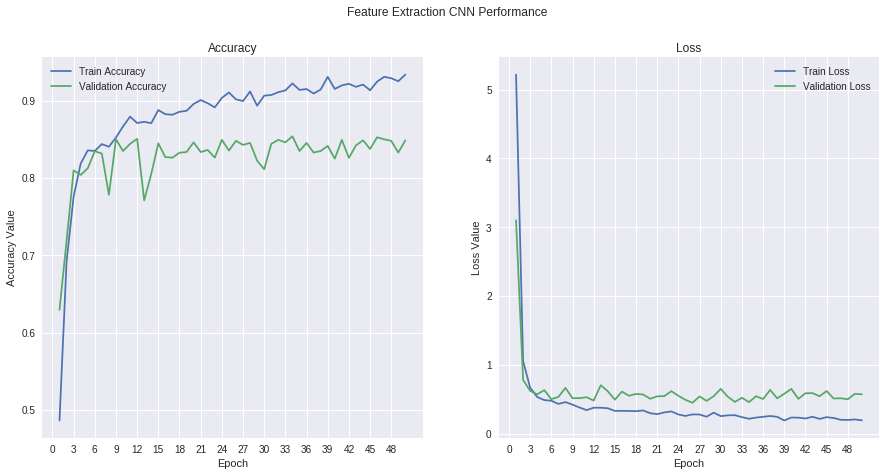

In [42]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
t = f.suptitle('Feature Extraction CNN Performance', fontsize=12)

epoch_list = list(range(1,51)) # Number of epochs used and it will be used as our X axis
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0,51, 3))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
ax1.legend(loc='best')


ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0,51, 3))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
ax2.legend(loc='best')

plt.show()

#### With Regularization

For the next model, we will use the dropout method as our regularization.

- What does the Dropout do?
  - The term dropout refers to dropping out units in a neural network.
  - So, during our training phase, a set of neurons are going to be chosen at random and it will be ignored. This means that during our forward and backward propagation this chosen set of neurons are not considered.
  - In the case below, we are dropping 0.3 of our neurons. This means that we are dropping 30% of the neurons available.
  
- When should we use Dropout?
  - Dropouts are usually used when our model is overfitting. The model computed above is not overfitting, but let's just see how it will perform in our model.

In [64]:
# Import EarlyStopping
from keras.callbacks import EarlyStopping   

model_r = Sequential()
model_r.add(vgg_model)
model_r.add(Dense(512, activation='relu', input_dim=(299,299,3)))
model_r.add(Dropout(0.3))  # Regularization
model_r.add(Dense(512, activation='relu'))
model_r.add(Dropout(0.3))  # Regularization
model_r.add(Dense(8, activation='softmax'))

model_r.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

early_stopping_monitor = EarlyStopping(patience=5)    
              
history = model_r.fit_generator(train_generator, 
                                steps_per_epoch = 100, 
                                epochs = 50,
                                validation_data = val_generator, 
                                validation_steps = 50,
                                callbacks = [early_stopping_monitor],
                                verbose = 1)   

Epoch 1/50
100/100 [==============================] - 102s 1s/step - loss: 2.0923 - acc: 0.4487 - val_loss: 0.9001 - val_acc: 0.7007
Epoch 2/50
100/100 [==============================] - 95s 947ms/step - loss: 1.0042 - acc: 0.6475 - val_loss: 0.7555 - val_acc: 0.7487
Epoch 3/50
100/100 [==============================] - 92s 916ms/step - loss: 0.9392 - acc: 0.6789 - val_loss: 0.7884 - val_acc: 0.7461
Epoch 4/50
100/100 [==============================] - 92s 918ms/step - loss: 0.9347 - acc: 0.6754 - val_loss: 0.8196 - val_acc: 0.7368
Epoch 5/50
100/100 [==============================] - 91s 910ms/step - loss: 0.8702 - acc: 0.7033 - val_loss: 0.6950 - val_acc: 0.8087
Epoch 6/50
100/100 [==============================] - 94s 944ms/step - loss: 0.8652 - acc: 0.6925 - val_loss: 0.6561 - val_acc: 0.8026
Epoch 7/50
100/100 [==============================] - 91s 915ms/step - loss: 0.8622 - acc: 0.7040 - val_loss: 0.7484 - val_acc: 0.7461
Epoch 8/50
100/100 [==============================] - 92s

In [0]:
model.save('drive/My Drive/furniture_categories/furniture_cnn_feature_extraction_Regularization_Dropout.h5')

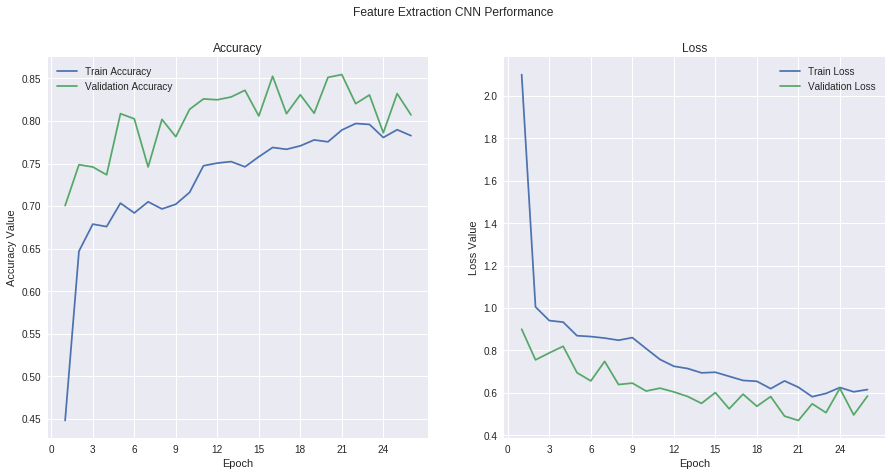

In [67]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
t = f.suptitle('Feature Extraction CNN Performance', fontsize=12)

epoch_list = list(range(1,27)) # Number of epochs used and it will be used as our X axis
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 27, 3))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
ax1.legend(loc='best')


ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0,27, 3))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
ax2.legend(loc='best')

plt.show()

As we can see, the model without dropout performed significantly better, achieving more than 10% higher accuracy. However, what is interesting in this model is that the validation accuracy was almost as high as the one without dropout, with a 83.3% validation accuracy.

#### Pre-trained model with fine-tuning

For us to fine-tune our model we need to change some of the blocks of the VGG-16 model to be trainable. So, let's have a look at the layers and see which ones we will unfreeze.

In [68]:
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_2,False
1,<keras.layers.convolutional.Conv2D object at 0...,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0...,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0...,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0...,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0...,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0...,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0...,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0...,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0...,block3_conv3,False


To fine-tune our model we will unfreeze two blocks, 4 and 5, while keeping the first three blocks frozen. By blocking the blocks 4 and 5, we will be unfreezing 9 layers.

In [69]:
set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_2,False
1,<keras.layers.convolutional.Conv2D object at 0...,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0...,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0...,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0...,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0...,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0...,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0...,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0...,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0...,block3_conv3,False


As we can see in the dataset above, the last 9 layers were unfrozen and are now trainable, which means that the weights for these layers will get updated with forward and backward propagation in each epoch. Now, let's train our model and see if we can generate a better prediction rate.

In [71]:
model_fn = Sequential()
model_fn.add(vgg_model)
model_fn.add(Dense(512, activation='relu', input_dim=(299,299,3)))
model_fn.add(Dense(512, activation='relu'))
model_fn.add(Dense(8, activation='softmax'))

model_fn.compile(loss= 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

history = model_fn.fit_generator(train_generator, 
                                 steps_per_epoch = 100, 
                                 epochs = 50, 
                                 validation_data = val_generator, 
                                 validation_steps = 50, 
                                 verbose=1)   

Epoch 1/50
100/100 [==============================] - 99s 989ms/step - loss: 5.9467 - acc: 0.4321 - val_loss: 0.9165 - val_acc: 0.6727
Epoch 2/50
100/100 [==============================] - 93s 926ms/step - loss: 0.7980 - acc: 0.7267 - val_loss: 0.6827 - val_acc: 0.7730
Epoch 3/50
100/100 [==============================] - 92s 922ms/step - loss: 0.6181 - acc: 0.7968 - val_loss: 0.5214 - val_acc: 0.8322
Epoch 4/50
100/100 [==============================] - 90s 903ms/step - loss: 0.5240 - acc: 0.8240 - val_loss: 0.6702 - val_acc: 0.7849
Epoch 5/50
100/100 [==============================] - 90s 902ms/step - loss: 0.5209 - acc: 0.8222 - val_loss: 0.5770 - val_acc: 0.8184
Epoch 6/50
100/100 [==============================] - 93s 934ms/step - loss: 0.4862 - acc: 0.8315 - val_loss: 0.5761 - val_acc: 0.8105
Epoch 7/50
100/100 [==============================] - 89s 895ms/step - loss: 0.4808 - acc: 0.8367 - val_loss: 0.5443 - val_acc: 0.8253
Epoch 8/50
100/100 [==============================] - 9

In [0]:
model.save('drive/My Drive/furniture_categories/furniture_cnn_fine_tuning.h5')

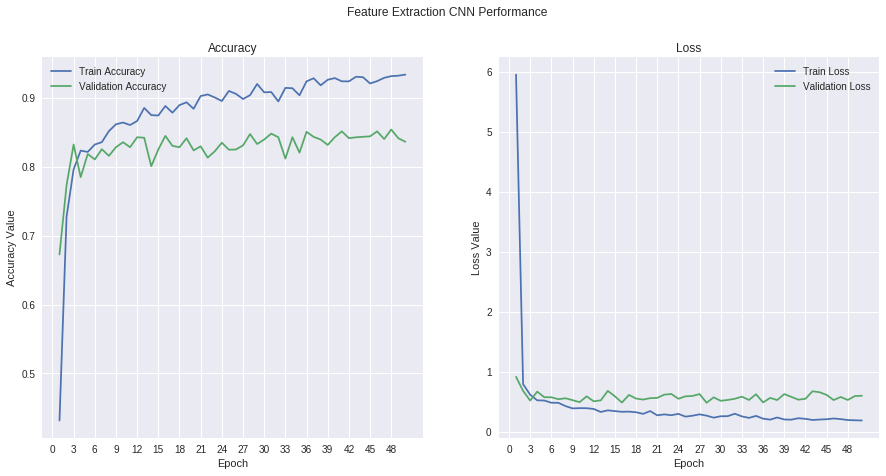

In [73]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
t = f.suptitle('Feature Extraction CNN Performance', fontsize=12)

epoch_list = list(range(1,51)) # Number of epochs used and it will be used as our X axis
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0,51, 3))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
ax1.legend(loc='best')


ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0,51, 3))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
ax2.legend(loc='best')

plt.show()

By fine-tuning the pre-trained model we achieved a result very similar to feature extraction without regularization, accuracy of 93.4% and validation accuracy of 83.6%

### InceptionV3

![alt text](https://lh3.googleusercontent.com/-wO5J1IBqwbs/WePLhUcJQBI/AAAAAAAAAqk/lv0TTx4TfYEm1hC993J-wj1woPuIYCxBACLcBGAs/s1600/model.png)

Above is the architecture of the InceptionV3 model. 

This model is well-known for how deep and complex it is. Just for comparison, the VGG-16 has a total of 23 layers while InceptionV3 has a total of 313 layers!

The key difference with Inception and other models is that rather than choosing whether to choose a convolutional filter of 5x5 or 3x3 or 2x2, it uses them all at different flows and then it stacks them up together with the concatenate function.
  - Just as we can see in the figure, the model has convolutional layers at a different flows, and at each flow the convolutional layers has a different filter dimension, and at the end, it concatenates it all together.
  - The model also uses a combination of Max pooling and Global Average pooling.
  - For regularization, the model makes use of BatchNormalization.
    - What is Batch Normalization?
      - Batch normalization is a technique used for improving the performance and stability of neural networks. It normalizes the inputs of each layer in such a way that they have a mean output activation of zero and standard deviation of one.
      - It is better implemented after each fully connected layer, but before the activation  function. as we can see in the InceptionV3 model summary below.
      - It is also seen as regularization, as it adds some noise to the network, similar to effect of Dropout.
      
   


Below, is the summary of the InceptionV3 model in detail.

In [74]:
from keras.applications.inception_v3 import InceptionV3


# Full InceptionV3 model architecture
base_inception_1 = InceptionV3(weights='imagenet', include_top=True, 
                             input_shape=(299, 299, 3))

base_inception_1.summary()

96116736/96112376 [==============================] - 2s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
____________________________________________

#### Feature extraction with InceptionV3

Now, let's use the InceptionV3 model as feature extraction, meaning that we will freeze all the layers to keep the trained weights and remove the fully connected layers for us to train our images.

In [0]:
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.applications.inception_v3 import InceptionV3

In [76]:
# Get the InceptionV3 model so we can do transfer learning
base_inception = InceptionV3(weights='imagenet', include_top=False, 
                             input_shape=(299, 299, 3)) 


87916544/87910968 [==============================] - 2s 0us/step


Now that we downloaded our model, let's freeze all the layers. 

In [77]:
base_inception.trainable = False
for layer in base_inception.layers:
  layer.trainable = False
        
layers = [(layer, layer.name, layer.trainable) for layer in base_inception.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_4,False
1,<keras.layers.convolutional.Conv2D object at 0...,conv2d_95,False
2,<keras.layers.normalization.BatchNormalization...,batch_normalization_95,False
3,<keras.layers.core.Activation object at 0x7fef...,activation_95,False
4,<keras.layers.convolutional.Conv2D object at 0...,conv2d_96,False
5,<keras.layers.normalization.BatchNormalization...,batch_normalization_96,False
6,<keras.layers.core.Activation object at 0x7fef...,activation_96,False
7,<keras.layers.convolutional.Conv2D object at 0...,conv2d_97,False
8,<keras.layers.normalization.BatchNormalization...,batch_normalization_97,False
9,<keras.layers.core.Activation object at 0x7fef...,activation_97,False


Now that we have all the layers frozen, let's build our fully connected layers.
We will call Global Average pooling to maintain the same structure as the model InceptionV3, but we will add 2 fully connected layers to be able train our images to the model.

  - Ps - By setting ''"include_top" to False, we removed the Global Average pooling and the prediction layer.

In [78]:
# Add a global spatial average pooling layer
out = base_inception.output # Get the output from the last layer.
out = GlobalAveragePooling2D()(out) # Call Global Average pooling
out = Dense(512, activation='relu')(out) # Fully connected
out = Dense(512, activation='relu')(out) # Fully connected
predictions = Dense(8, activation='softmax')(out)


model = Model(inputs=base_inception.input, outputs=predictions)


# Compile 
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 149, 149, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 149, 149, 32) 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_96 

In [79]:
batch_size = BATCH_SIZE
train_steps_per_epoch = x_train.shape[0] // batch_size
val_steps_per_epoch = x_val.shape[0] // batch_size

history = model.fit_generator(train_generator,
                              steps_per_epoch = train_steps_per_epoch,
                              validation_data = val_generator,
                              validation_steps = val_steps_per_epoch,
                              epochs=50,
                              verbose = 1)

Epoch 1/50
64/64 [==============================] - 48s 758ms/step - loss: 1.1641 - acc: 0.6083 - val_loss: 0.8457 - val_acc: 0.7199
Epoch 2/50
64/64 [==============================] - 38s 600ms/step - loss: 0.6769 - acc: 0.7712 - val_loss: 0.8047 - val_acc: 0.7590
Epoch 3/50
64/64 [==============================] - 41s 641ms/step - loss: 0.5973 - acc: 0.8004 - val_loss: 0.5481 - val_acc: 0.8042
Epoch 4/50
64/64 [==============================] - 40s 627ms/step - loss: 0.4815 - acc: 0.8350 - val_loss: 0.6772 - val_acc: 0.7983
Epoch 5/50
64/64 [==============================] - 40s 621ms/step - loss: 0.4691 - acc: 0.8449 - val_loss: 0.5756 - val_acc: 0.8283
Epoch 6/50
64/64 [==============================] - 42s 659ms/step - loss: 0.3851 - acc: 0.8729 - val_loss: 0.6121 - val_acc: 0.8373
Epoch 7/50
64/64 [==============================] - 40s 621ms/step - loss: 0.3768 - acc: 0.8696 - val_loss: 0.8155 - val_acc: 0.7801
Epoch 8/50
64/64 [==============================] - 39s 616ms/step - 

In [0]:
model.save('drive/My Drive/furniture_categories/furniture_cnn_inception_feature_extraction.h5')

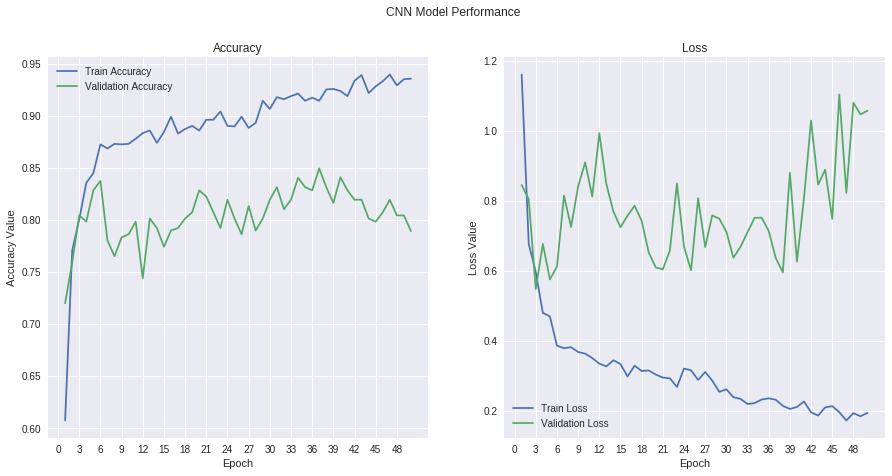

In [81]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
t = f.suptitle('CNN Model Performance', fontsize=12)

epoch_list = list(range(1,51)) # Number of epochs used and it will be used as our X axis
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0,51, 3))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
ax1.legend(loc='best')


ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0,51, 3))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
ax2.legend(loc='best')

plt.show()

The model was able to achieve a slightly higher accuracy than VGG-16, 93.6% accuracy. However, the validation accuracy was significantly lower, 78.2%.

### Result

By leveraging transfer learning from VGG-16 model as feature extractor to our model, we achieved an impressive result of 93.6% accuracy and 85% validation accuracy, even though we only had a total of 3’699  images available in our dataset. Thus, being able to prove that you don’t need to have large dataset with hundreds of thousands of images to get good results.